# Periodic discrete functions

In practice, of course, we cannot manipulate infinite grid functions numerically. The next best thing is to assume periodicity in space. We will assume $u(x)$ is $2\pi$-periodic and discretize it over $(0,2\pi]:$

$$
x_i = ih, \qquad h = \frac{2\pi}{N}, \qquad i=1,\ldots,N. 
$$

We let $v_i=u(x_i)$ and, when convenient, allow $v$ to be extended periodically by assuming $v_{j+mN}=v_j$ for all integers $j$ and $m$. 

```{caution}
We assume throughout that $N$ is even. The formulas for odd $N$ are usually different.
```

## Discrete Fourier transform

Previously, discretization of the function $u$ on the whole real line caused its transform to be confined to $k \in (-\pi/h,\pi/h]$. Now, confining the function to $[0,2\pi]$ also causes $k$ to be discretized. Since $\pi/h=N/2$, in fact, we have

$$
k \in \left\{ -\frac{N}{2}+1,-\frac{N}{2}+2,\ldots,\frac{N}{2} \right\}. 
$$


::::{prf:definition} Discrete Fourier transform
The **discrete Fourier transform** of a discretized, periodic function $v_j$ is 

$$
\mathcal{F}_N[u](k) = \hat{v}_k = h \sum_{j=1}^N e^{-ikx_j}\, v_j, \qquad  k = -\tfrac{N}{2}+1,-\frac{N}{2}+2,\ldots,\tfrac{N}{2}. 
$$

Its inverse is

$$
v_j = \frac{1}{2\pi} \sum_{k=1-(N/2)}^{N/2} e^{ikx_j}\, \hat{v}_k, \qquad  j=1,\ldots,N. 
$$
::::

## Sawtooth mode

The inverse transform formula above has an asymmetry with respect to the mode at 

$$
k = \pm \frac{\pi}{h} = \pm \frac{N}{2}. 
$$

(These are equivalent wavenumbers on the grid, by aliasing.) This is called the **sawtooth** Fourier mode, because

$$
\exp\left[ i \frac{N}{2} x_j \right] = \exp\left[ i \frac{\pi}{h} (jh) \right] = (-1)^j,
$$

i.e., the sawtooth mode toggles between $1$ and $-1$ on the grid. 

The inverse transform as given above puts all the content in $k=+N/2$, which is fine for the transform itself, but implies a complex derivative $\pm (iN/2)$ on the grid that is not in keeping with what the sawtooth itself suggests. 

The remedy is to split the content in the sawtooth mode evenly between the equivalent wavenumbers:

$$
v_j = \frac{1}{2\pi} \sideset{}{'}\sum_{k=-N/2}^{N/2} e^{ikx_j}\, \hat{v}_k, \qquad  j=1,\ldots,N,
$$

where the prime on the sum means to apply a factor of $1/2$ to the first and last terms. For the transform itself, this makes no change, but at the sawtooth mode, we now differentiate 

$$
\frac{1}{2}\left( e^{iNx/2} + e^{-iNx/2} \right) = \cos\left(\frac{Nx}{2}\right), 
$$

which has derivative zero on the grid.

Before leaving this subject, we point out that the situation above arises only for odd-numbered derivatives. For an even derivative, both forms of the sawtooth yield the same (real) values on the grid, and either form of the transform can be used for band-limited interpolation.

## Differentiation matrix

The band-limited interpolant is now 

$$
p(x) = \frac{1}{2\pi} \sideset{}{'}\sum_{k=-N/2}^{N/2} e^{ikx}\, \hat{v}_k,
$$

for $x\in(0,2\pi]$. As always, we can differentiate this interpolant and evaluate it on the grid. But to derive a column of the differentiation matrix, we only need to apply the process to the discrete periodic $\delta$, where $d_j=1$ for all $j=mN$ and $d_j=0$ otherwise. The resulting $p$ is the periodic version of the sinc function:

$$
S_N(x) = \frac{\sin(\pi x/h)}{(2\pi/h)\tan(x/2)},
$$

which interpolates the discrete delta while also being $2\pi$-periodic. The entries of column 0 in the differentiation matrix $\bfD_N$ are

$$
S'_N(x_j) = \begin{cases}
  0, & j=0 (\mod N), \\ 
  \tfrac{1}{2}(-1)^j\cot({jh}/2), & j \neq 0 (\mod N).
  \end{cases}
$$

Naturally, column 0 is the same as column $N$, and the rest of the columns are shifted versions of it. The result is again a circulant matrix. 

### p4: periodic spectral differentiation

In [1]:
using LinearAlgebra
N = 24

# Set up grid and differentiation matrix:
h = 2π / N
x = h * (1:N)
entry(k) = k==0 ? 0.0 : 0.5 * (-1)^k * cot(k * h / 2)
D = [ entry(mod(i-j,N)) for i in 1:N, j in 1:N ]

# Differentiation of a hat function:
v = @. max(0, 1 - abs(x - π) / 2)
w = D*v
hat = (;v, w)

# Differentiation of exp(sin(x)):
v = @. exp(sin(x))
vʹ = @. cos(x) * v
w = D*v
error = norm(w - vʹ, Inf)
smooth = (;v, w, error);

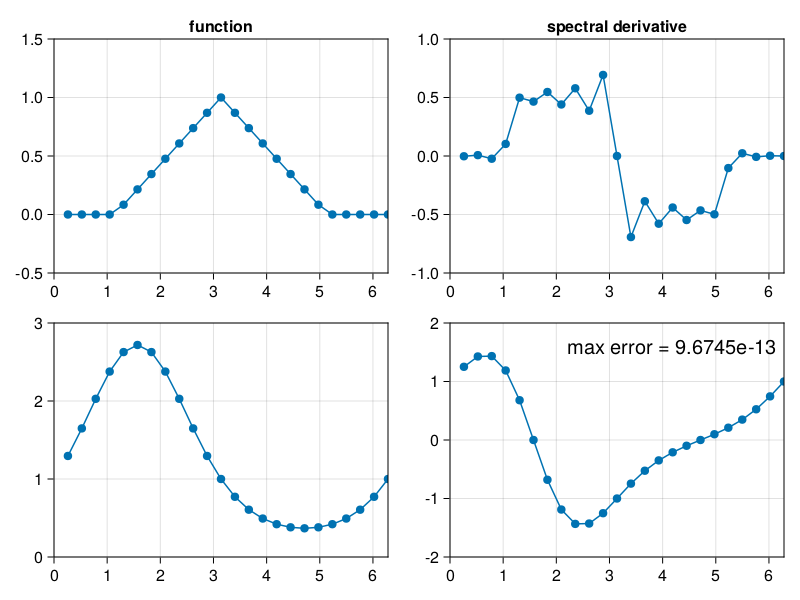

In [2]:
using CairoMakie, PyFormattedStrings

fig = Figure()
ax = Axis(fig[1, 1], title="function")
scatterlines!(x, hat.v)
limits!(ax, 0, 2π, -0.5, 1.5)
ax = Axis(fig[1, 2], title="spectral derivative")
scatterlines!(x, hat.w)
limits!(ax, 0, 2π, -1, 1)

ax = Axis(fig[2, 1])
scatterlines!(x, smooth.v)
limits!(ax, 0, 2π, 0, 3)
ax = Axis(fig[2, 2])
scatterlines!(x, smooth.w)
limits!(ax, 0, 2π, -2, 2)
text!(2.2, 1.4, text=f"max error = {smooth.error:.5g}", textsize=20)
fig

The differentiation of the nonsmooth function is very poor, but for the smooth case, it's very accurate.

As before, we can differentiate $S_N$ twice to get a differentiation matrix for the second derivative. (See textbook.)

## FFT

In the previous section, we observed that one can operate in wavenumber space rather than physical space in order to compute the derivative of a grid function. The same applies in the periodic context:

1. Set $\hat{w}_k = i k\, \hat{v}(k)$, except $\hat{w}_{N/2}=0$.
2. Let $w = \mathcal{F}_N^{-1}[\hat{w}]$. 

For the $v$th derivative, the factor in passing from $\hat{v}$ to $\hat{w}$ is $(ik)^\nu$, except it must be set to zero if $v$ is odd.

This pathway becomes acutely relevant because of the **Fast Fourier Transform**, credited to Cooley and Tukey in modern times but going back to Gauss. The FFT allows computation of the DFT and IDFT in $O(N\log N)$ operations, versus the $O(N^2)$ of a naive DFT implementation as well as for matrix-vector multiplication in physical space. Asymptotically, the FFT pathway should be the fastest by far, although the $N$ at which it begins to have an advantage is not clear in advance.

In the following code we show how to exploit the fact that a real function has a transform with conjugate symmetry, so that only the first half of the transform needs to be computed explicitly. 

### p5: repetition of p4 via FFT

In [3]:
using FFTW 

# real case
function fderiv(v::Vector{T}) where T <: Real
    N = length(v)
    v̂ = rfft(v)
    ŵ = 1im * [0:N/2-1; 0] .* v̂
    return irfft(ŵ, N) 
end

# general case (2x slower)
function fderiv(v)
    N = length(v)
    v̂ = fft(v)
    ŵ = 1im * [0:N/2-1; 0; -N/2+1:-1] .* v̂
    return ifft(ŵ)
end

N = 24

# Set up grid and differentiation matrix:
h = 2π / N
x = h * (1:N)

# Differentiation of a hat function:
v = @. max(0, 1 - abs(x - π) / 2)
w = fderiv(v)
hat = (;v, w)

# Differentiation of exp(sin(x)):
v = @. exp(sin(x))
vʹ = @. cos(x) * v
w = fderiv(v)
error = norm(w - vʹ, Inf)
smooth = (;v, w, error);

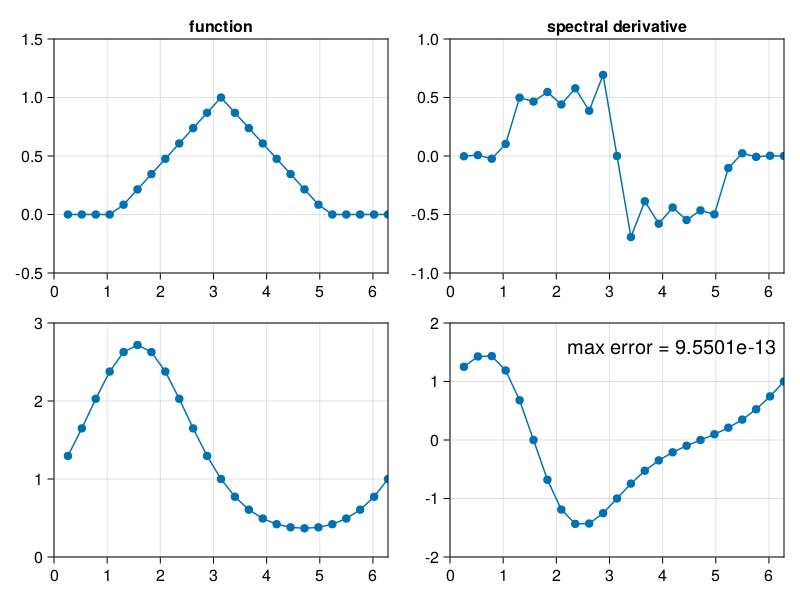

In [4]:
using CairoMakie, PyFormattedStrings

fig = Figure()
ax = Axis(fig[1, 1], title="function")
scatterlines!(x, hat.v)
limits!(ax, 0, 2π, -0.5, 1.5)
ax = Axis(fig[1, 2], title="spectral derivative")
scatterlines!(x, hat.w)
limits!(ax, 0, 2π, -1, 1)

ax = Axis(fig[2, 1])
scatterlines!(x, smooth.v)
limits!(ax, 0, 2π, 0, 3)
ax = Axis(fig[2, 2])
scatterlines!(x, smooth.w)
limits!(ax, 0, 2π, -2, 2)
text!(2.2, 1.4, text=f"max error = {smooth.error:.5g}", textsize=20)
fig

## Method of lines

Here is a solution of the variable-coefficient advection PDE

$$
\partial_t u + c(x) \partial_x u = 0, \qquad c(x) = \frac{1}{5} + \sin^2(x-1). 
$$

Note that the velocity is $2\pi$-periodic, which is required for periodic boundary conditions to work as intended. 

This function applies the midpoint/leapfrog method in time, with FFT-based spectral differentiation in space:

### p6: variable coefficient wave equation

In [5]:
using FFTW

function p6(⍺ = 1.57)
    # Grid, variable coefficient, and initial data:
    N = 128;  h = 2π / N
    x = h * (1:N)
    t = 0;  Δt = ⍺ / N
    c = @. 0.2 + sin(x - 1)^2
    v = @. exp(-100 * (x - 1) .^ 2)
    vold = @. exp(-100 * (x - 0.2Δt - 1) .^ 2)

    # Time-stepping by leap frog formula:
    tmax = 8
    nsteps = ceil(Int, tmax / Δt)
    Δt = tmax / nsteps
    V = [v fill(NaN, N, nsteps)]
    t = Δt*(0:nsteps)
    for i in 1:nsteps
        w = fderiv(V[:,i])
        V[:,i+1] = vold - 2Δt * c .* w
        vold = V[:,i]
        if norm(V[:,i+1], Inf) > 2.5
            nsteps = i
            break 
        end
    end
    return x,t[1:nsteps+1],V[:,1:nsteps+1]
end

x,t,V = p6(1.57);

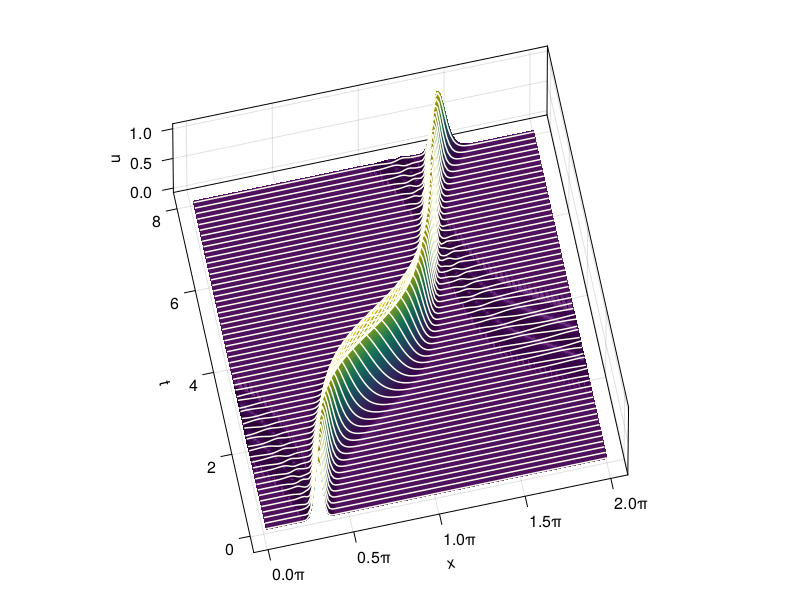

In [6]:
using CairoMakie, PyFormattedStrings

fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.3,
)
gap = max(1,round(Int, 0.15/(t[2]-t[1])) - 1)
surface!(x, t, V, colorrange=(0,1))
[ lines!(x, fill(t[j], length(x)), V[:, j].+.01, color=:ivory) for j in 1:gap:size(V,2) ]
fig

In [7]:
fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="u"
)
lines!(x, @lift(V[:,$index]))
record(fig, "p6.mp4", 1:4:size(V,2)+1) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
end;

<video autoplay width=480 controls><source src="p6.mp4" type="video/mp4"></video>

In the simulation above, you can see a small artifact that travels in the wrong direction. The accuracy of this simulation is limited by the second-order time stepping, and even more by the need to estimate the fictitious value $u(x,-\Delta t)$ that leap frog needs to get started. An automatic, self-starting IVP solver would do much better.